In [87]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point

import pickle
# import module from the parent directory
import sys
import os

working_directory = os.path.dirname(os.getcwd())
sys.path.append(working_directory)

In [146]:
# reload the library
import importlib

importlib.reload(sys.modules['topoMap'])
from topoMap import computeTransLimit

In [4]:
with open('../data_pe/cluster_results.pkl', 'rb') as f:
    res = pickle.load(f)

transitionProbsEdit, id_coorders_mapping_edit, stationary, cluster_labels = res
keylist = list(id_coorders_mapping_edit.keys())

In [12]:
shenzhen_grid = gpd.read_file('../data/shenzhen_grid/shenzhen_grid.shp')

d:\Application\Conda\envs\geoneuro\lib\site-packages\pandas\core\dtypes\cast.py:126: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


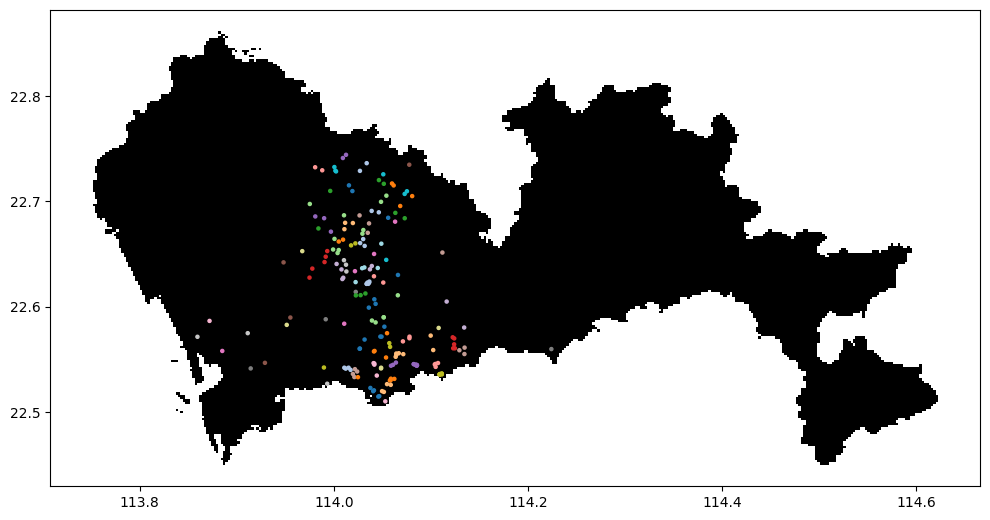

In [52]:
# plot the shenzhen grid
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
shenzhen_grid.plot(ax=ax, edgecolor='none', facecolor='black')

# plot the clustered points, color-coded by cluster
# create the points geopandas dataframe
points = pd.DataFrame()
points['geometry'] = [Point(id_coorders_mapping_edit[key]) for key in keylist]
points['cluster'] = cluster_labels
points = gpd.GeoDataFrame(points, crs=4326, geometry='geometry')
points.plot(ax=ax, column='cluster', legend=True, markersize=5, cmap='tab20')
# ref off the color legend
# ref brute force method:
fig.delaxes(fig.axes[1])


In [53]:
fig.savefig('clustered_points.png')

In [45]:
explore = points.explore("cluster", cmap='tab20', marker_kwds={'radius': 8})
explore.save('./Topomap.html')

In [220]:
# average the coordinates of the points in each cluster
labpos = [np.where(cluster_labels == lab)[0] for lab in np.unique(cluster_labels)]
transitionClust = np.empty((len(labpos), len(labpos)))
for i in range(len(labpos)):
    source = transitionProbsEdit[labpos[i], :].mean(axis=0)
    for j in range(len(labpos)):
        transitionClust[i, j] = source.take(labpos[j]).sum()
        
transitionClust /= transitionClust.sum(axis=1)[:, None]

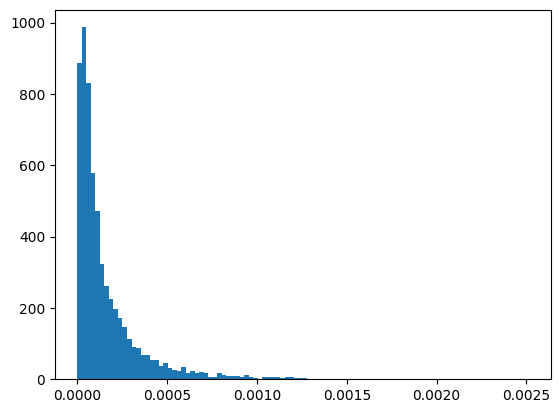

In [202]:
weight = computeTransLimit(transitionClust).real
transitionCorrected = transitionClust * weight
plt.hist(transitionCorrected.flatten(), bins=100)
plt.show()


In [240]:

# ref 矩阵中的累积最小值
# search the position where sits the smallest values whose cumulated sum is larger than 0.05
threshold = 0.5
transitionCorrectedFlatten = transitionCorrected.flatten()
sorted = np.sort(transitionCorrectedFlatten)
cut_pos = len(np.where(np.cumsum(sorted) <= threshold)[0])
smalllest_idx = np.argsort(transitionCorrectedFlatten)[:cut_pos]
# transitionCorrectedFlatten[smalllest_idx] = np.nan
smalllest_idx_2d = np.unravel_index(smalllest_idx, transitionCorrected.shape)

weighgFlatten = weight.flatten()
sorted = np.sort(weighgFlatten)
cut_pos = len(np.where(np.cumsum(sorted) <= threshold)[0])
smalllest_idx_weight = np.argsort(weighgFlatten)[:cut_pos]

In [241]:
transAdj = transitionCorrected.copy()
transAdj[smalllest_idx_2d] = 0

In [242]:
# get the average position of the points in each cluster
cluster_coords_array = []
for onelab2pos in labpos:
    cluster_coords_list = [id_coorders_mapping_edit[keylist[onepos]] for onepos in onelab2pos]
    cluster_coords = np.array(cluster_coords_list).mean(axis=0)
    cluster_coords = tuple(cluster_coords.tolist())
    cluster_coords_array.append(cluster_coords)


In [243]:

def draw_pentagram(ax, position, size=0.01, color='red'):
    # Points of a regular pentagon
    pentagon = np.array([[np.cos(2 * np.pi * i / 5), np.sin(2 * np.pi * i / 5)] for i in range(5)])
    pentagon = size * pentagon + position

    # Draw lines for the star
    for i in range(5):
        start = pentagon[i]
        end = pentagon[(i + 2) % 5]
        ax.plot([start[0], end[0]], [start[1], end[1]], color=color)

def drawNetworkOnMap(shenzhen_grid,  alpha=0.2):
    print("Function starts.")

    # Create a graph from the CSV data
    G = nx.DiGraph()
    for i, coord in enumerate(cluster_coords_array):
        if not np.isin(i, smalllest_idx_weight):
            G.add_node(str(coord), pos=coord, weight=weight[i, 0])

    # count = 10
    size = len(cluster_coords_array)
    for i in range(size):
        if np.isin(i, smalllest_idx_weight):
            continue
        for j in range(size):
            if i != j and not np.isin(j, smalllest_idx_weight):
                weight_value = transAdj[i, j]
                if weight_value > 0:
                    G.add_edge(str(cluster_coords_array[i]), str(cluster_coords_array[j]), weight=weight_value)
    # Extract and scale weights for the edges
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    print("weights: ", weights)
    alphaw = np.interp(weights, (min(weights), max(weights)), (0, 1))
    # Extract the size weighs for the nodes
    node_size = [G.nodes[n]['weight'] for n in G.nodes()]
    print("node_size: ", node_size)
    node_size = np.log(np.array(node_size))
    node_size = np.interp(node_size, (min(node_size), max(node_size)), (10, 100))
    # Position
    pos = nx.get_node_attributes(G, 'pos')
    # Plot the network on the map
    f, ax = plt.subplots(1, 1, figsize=(20, 20))
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_size)
    nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights, 
                           edge_vmax=max(weights),
                           edge_cmap=plt.cm.Reds, arrows=True, arrowstyle='-|>', ax=ax)
    shenzhen_grid.plot(ax=ax, linewidth=1, alpha=alpha)

    plt.show()

Function starts.
weights:  [0.0012382604567747204, 0.000932022118599141, 0.0006941621465214255, 0.0010483146268194636, 0.0012285887103358933, 0.0017853605149637773, 0.0008160314604171588, 0.0009191635823485395, 0.0007960229183166636, 0.0007942528960061822, 0.0008484614452256614, 0.0011323233325483814, 0.0008695628741730321, 0.00173416442300732, 0.0011049100555995956, 0.0010706831986672673, 0.0007927882425129982, 0.002146534718670174, 0.0014684612831335274, 0.000475832963590176, 0.0005919407345412669, 0.0005834791991256744, 0.0009752357061798741, 0.00115091525667469, 0.0007854137836895061, 0.0007123187283003294, 0.0004965914996016846, 0.0005255827314477679, 0.0005674711645361103, 0.0007799877143278223, 0.00067765728859515, 0.0010804795823981571, 0.0008715938680699406, 0.0006415916767669907, 0.0007989711465942932, 0.0015815710569557742, 0.0008551616842967574, 0.0006347739245922734, 0.00038537082263914165, 0.0005113750744755011, 0.0006203032725149423, 0.0009314316512602969, 0.000433081598

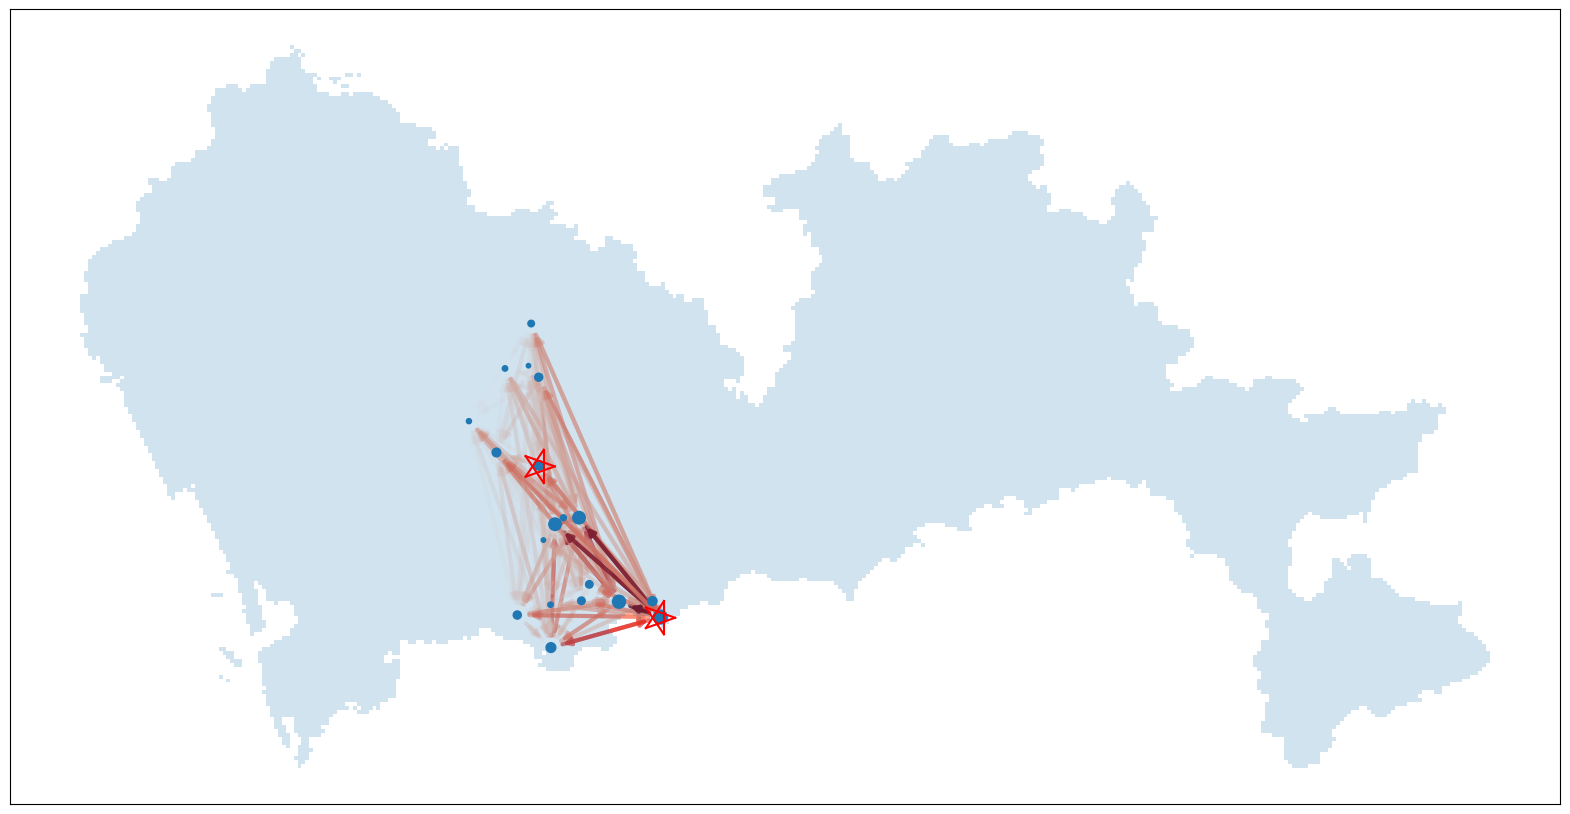

In [244]:
drawNetworkOnMap(shenzhen_grid, alpha=0.2)